# EDA

#### Imports:

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from google.colab import files
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

### Reading in the CSV file:

In [25]:
df = pd.read_csv("./data/cleaned_data.csv",  index_col='business_date',  ).drop('Unnamed: 0', axis=1)

In [26]:
df.index = pd.to_datetime(df.index)

In [27]:
len(df.market_code.unique())

11

11 Unique Market Segments

For project's purpose the data will be looked at from two viewpoints: Rooms sold on a daily basis represented in 'no_definite_rooms' column and Revenue gained every day in 'revenue' column. 

Let's take a broad look at the data and how it is shaped. First Rooms Sold:

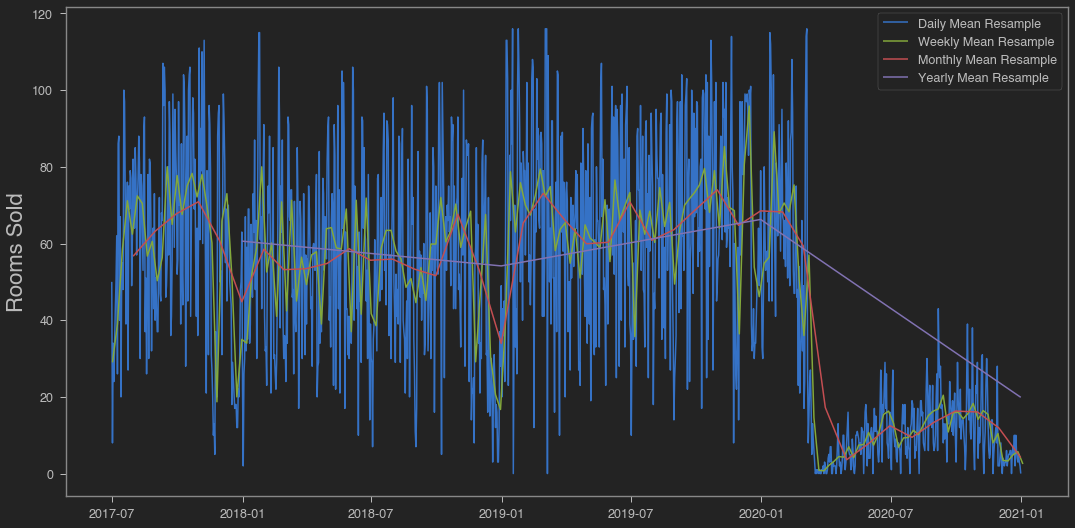

In [35]:
y = df.resample('D')['no_definite_rooms'].sum()
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(y.resample('D').mean(),linestyle='-', label='Daily Mean Resample')
ax.plot(y.resample('W').mean(),linestyle='-', label='Weekly Mean Resample')
ax.plot(y.resample('M').mean(),linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),linestyle='-', label='Yearly Mean Resample')

ax.set_ylabel('Rooms Sold', fontsize=22)
ax.legend(fontsize=20)
ax.legend();

There are couple of immediate observations here:

- the sudden drop to the right is due to Covid-19 and the hotel only operating for essential personnel
- there seems to be no overall trend from the annual perspective. The green line representing annual resample is relatively flat
- there are no days where rooms sold number is higher than the capacity of the hotel (120)
- there is some annual seasonality on a monthly level as seen in dips towards the end of each year (holiday season)
- there may be weekly seasonality which cannot be determined from this graph.

Now let's take a look at revenue data:

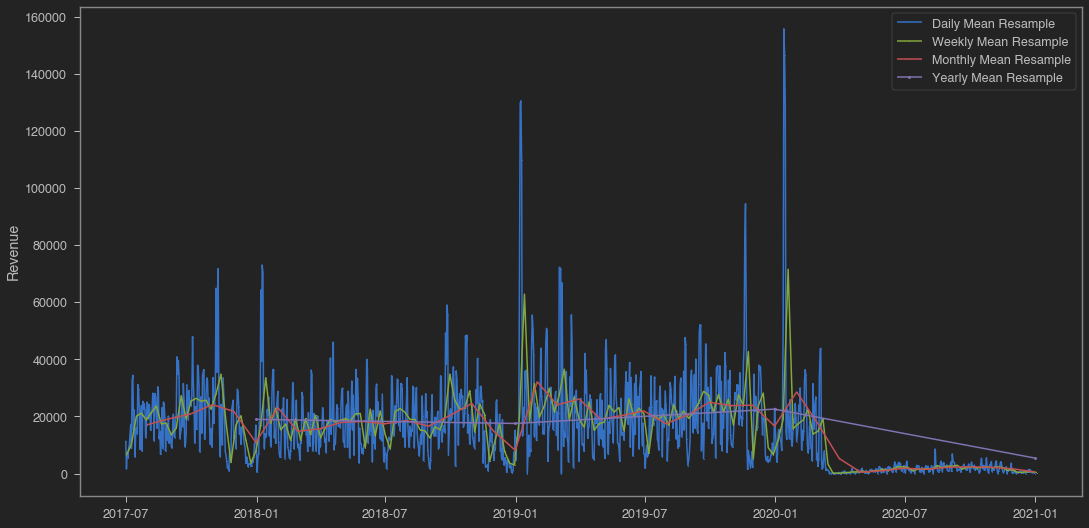

In [36]:
y = df.resample('D')['revenue'].sum()
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(y.resample('D').mean(),marker='o', markersize=1, linestyle='-', label='Daily Mean Resample')
ax.plot(y.resample('W').mean(),marker='o', markersize=1, linestyle='-', label='Weekly Mean Resample')
ax.plot(y.resample('M').mean(),marker='o', markersize=1, linestyle='-', label='Monthly Mean Resample')
ax.plot(y.resample('Y').mean(),marker='o', markersize=3, linestyle='-', label='Yearly Mean Resample')

ax.set_ylabel('Revenue')
ax.legend();

Since rooms and revenue are expected to be correlated (the more rooms sold, the higher the revenue), this graph looks almost identical albeit at a different scale.

- the spikes represent big conventions in San Francisco that raise the hotel rooms demand and result in extreme room prices. January spikes fall on dates of JPMorgan conventions and October/November spikes represent Salesforce and Oracle. 
- the data (excluding 2020) seems to have no trend, but stil needs to be checked for stationarity for use in time series models.

Running an Augmented Dickey Fuller test to check for stationarity:

In [8]:
print(f'Rooms ADF test: {adfuller(df["no_definite_rooms"])}')
print(f'Rooms ADF test: {adfuller(df["revenue"])}')
   

Rooms ADF test: (-6.8264844063432655, 1.9419934100737604e-09, 37, 9216, {'1%': -3.4310597571975685, '5%': -2.8618536675227677, '10%': -2.5669369601558167}, 71680.92745454167)
Rooms ADF test: (-9.727564233908703, 9.187072356670721e-17, 38, 9215, {'1%': -3.4310598342409824, '5%': -2.8618537015669867, '10%': -2.5669369782777083}, 182124.13227133418)


We can see that our statistic values of -6.8 and -9.7 are less than the values of -3.43 at 1%. Moreover, the p-values are insignificant. This suggests that we can reject the null hypothesis (data is non-stationary) with a significance level of less than 1%.

Decompositon charts will give a good look at overall data as well:

<ipython-input-52-0e0680b9c0ca>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df['no_definite_rooms'], model='additive', freq=365)


<Figure size 576x504 with 0 Axes>

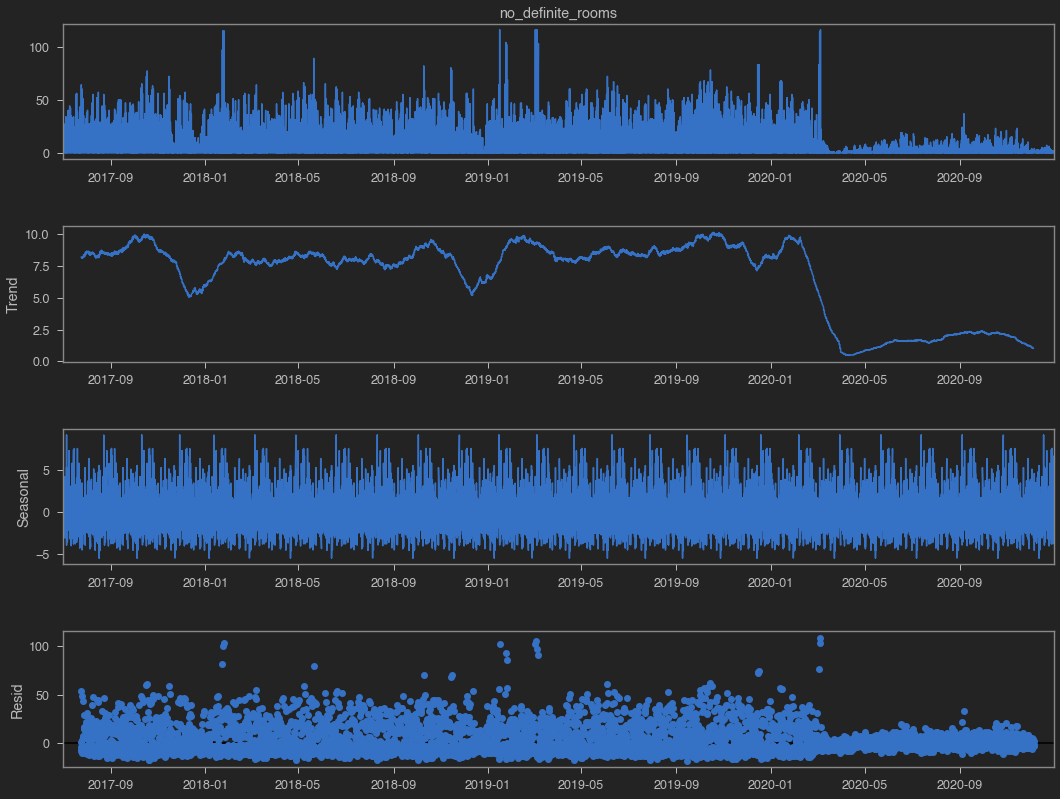

In [52]:
result = seasonal_decompose(df['no_definite_rooms'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 12)

From the trend view we see that there is a seasonal component on an annual level and there is seasonality present.

<ipython-input-54-f48c591dafc8>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df['revenue'], freq=365)


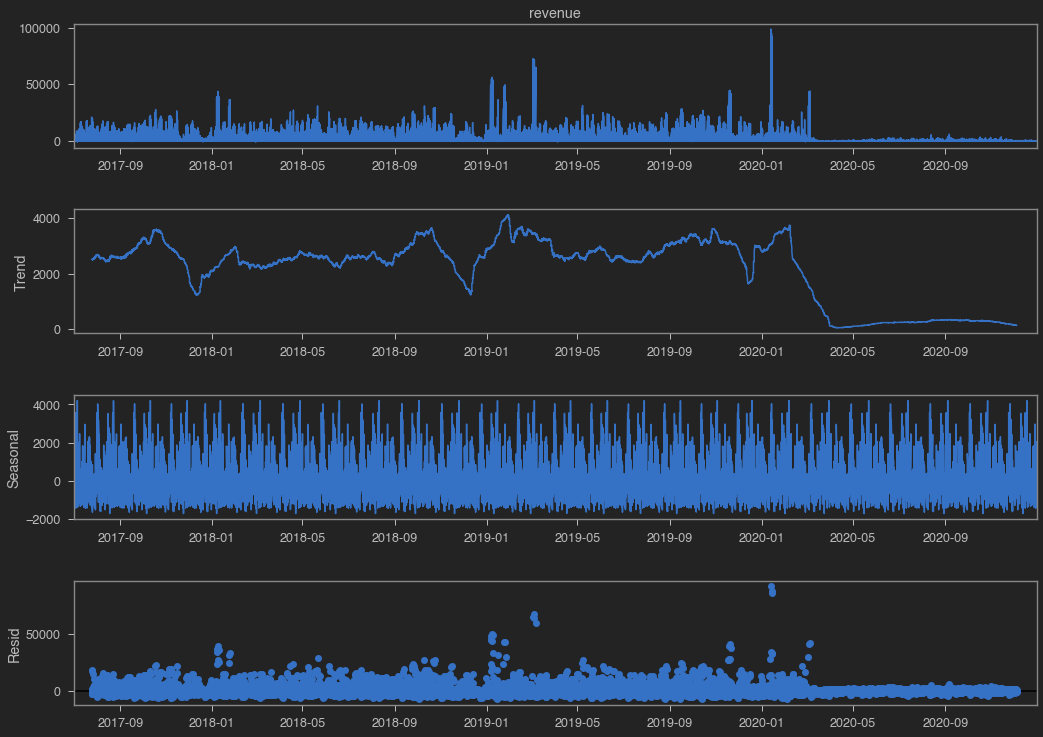

In [54]:
decomposition = seasonal_decompose(df['revenue'], freq=365)
fig = decomposition.plot()
fig.set_size_inches(16,11)
plt.show();

Very similar findings to the ones in Rooms data: there is seasonality on an annual level.

There is no trending observed until March 2020, when a downward trend starts to appear showing the impact of Covid-19. Let's take a look at autocorrelation plot:

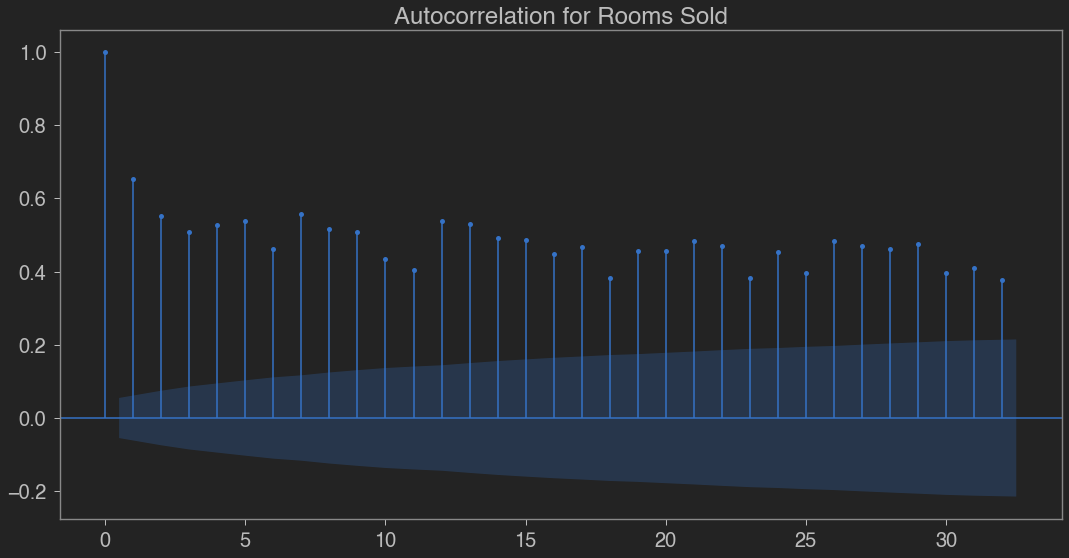

In [55]:
fig, ax = plt.subplots(figsize=(16,9))
plot_acf(df.resample('D')['no_definite_rooms'].sum(), ax=ax)
# Decoration
plt.title('Autocorrelation for Rooms Sold', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show();

Based on the ACF plot there is evidence of a trend since the small lag values have large, positive autocorrelations. The "scalloped" shape of the graph shows a seasonal cycle at every 5-7 lags (weekly) for MA(1). If it was MA(2) we would see two spikes lag1 and lag2, repeated in a weekly cycle. Because of this, we will use a value of MA(1) for the baseline model. Now let's take a look at PACF:

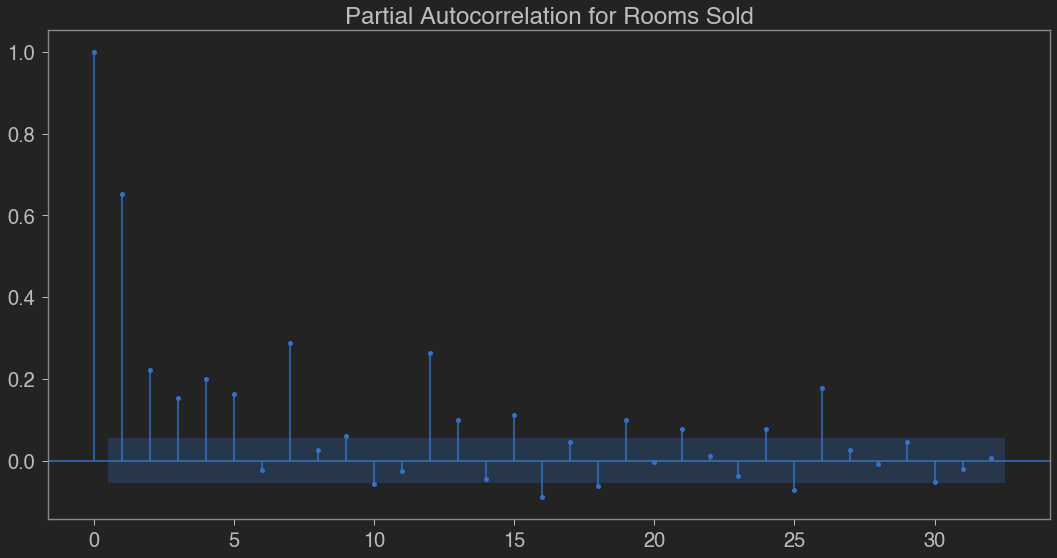

In [56]:
fig, ax = plt.subplots(figsize=(16,9))
plot_pacf(df.resample('D')['no_definite_rooms'].sum(), ax=ax)
# Decoration
plt.title('Partial Autocorrelation for Rooms Sold', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show();

This plots the correlation at a given lag (indicated by the horizontal axis), controlling for all of the previous lags. In the PACF plot we see some positive and some negative significant partial autocorrelations, which usually indicates strong seasonal fluctuations.
There is a large dropoff after lag 1, which gives us the value for AR(1). This view also confirms seasonality at the weekly level as we see spikes on lag 7, 15, 21. However, this seasonality is not very strong. Let's explore daily revenue:

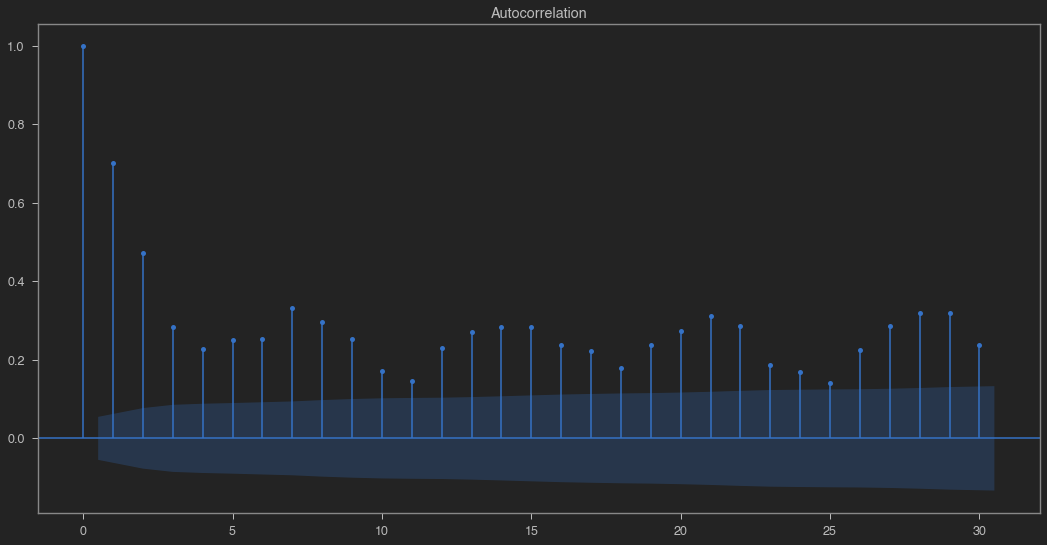

In [57]:
fig, ax = plt.subplots(figsize=(16,9))
plot_acf(df.resample('D')['revenue'].sum(), ax=ax, lags=30);

For an autoregressive (AR) time series, the ACF will go down gradually without any sharp cut-off, which is observed here. There is a MA(1) here, similar to rooms. 
This ACF tells us it is an AR series as well, then we turn to the PACF:

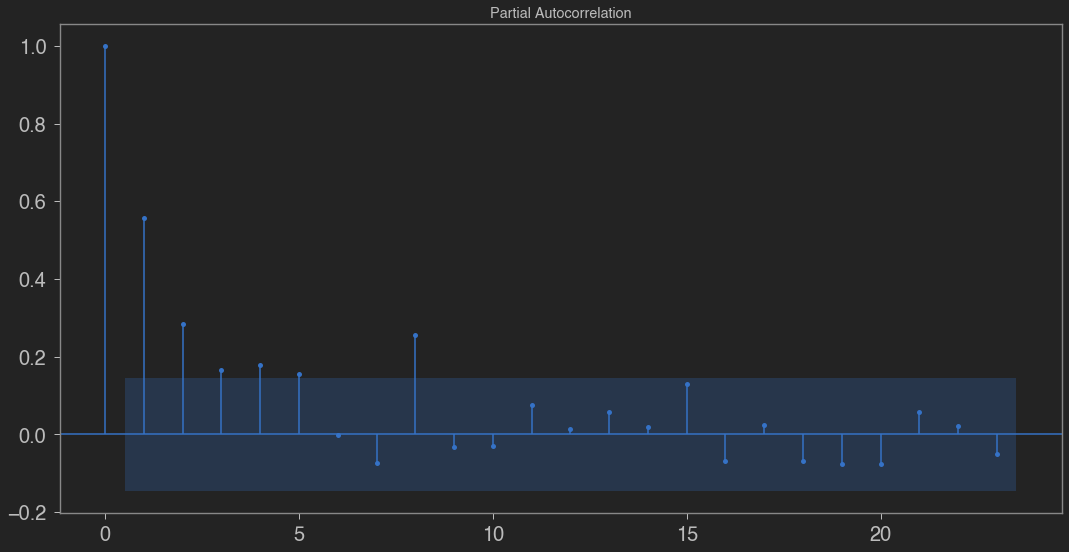

In [58]:
fig, ax = plt.subplots(figsize=(16,9))
plot_pacf(df.resample('W')['revenue'].sum(), ax=ax)
# Decoration
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show();

Very similar seasonal pattern, except this tells AR also looks to be AR(1). We are seeing one big spike, then starts to converse towards zero.

## Conclusion

As graphing of the data shows, we are dealing with stationary, seasonal time series data and should explore time series models with AR(1) and MA(1). ARIMA would be a great choice as it incorporates both and SARIMA could be useful as we have seasonality in our data. 
As we have highly sequential data, other types of models that should be considered for this project are: 
- Long Short-Term Memory(LSTM) Recurrent Neural Network
- Gated Recurrent Unit(GRU) Recurrent Neural Network